# RNN - LSTM : 3 epochs and 0.2 of dataset

In [1]:
import os
import pandas as pd

path = "data/text_classification/"

# dataset dict with emtpy attribute train
dataset = pd.DataFrame()

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = pd.read_csv(path + file, sep=";")
        dataset = pd.concat([dataset, new_data], ignore_index=True)

dataset

,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,Comment puis-je rejoindre Persan à partir de S...,1,0,0,0
1,Je prévois un voyage de VILLEFRANCHE-DE-CONFLE...,1,0,0,0
2,Go from the city of Sarlat La Caneda to Souillac.,0,1,0,0
3,What is the best way to go from Allamps-Esat t...,0,1,0,0
4,zg xqmajyjpfxsvvgycgqd c e i y ehgbcf f e o...,0,0,0,1
...,...,...,...,...,...
1528934,Tom met Mary in the lobby of the building.,0,1,1,0
1528935,Trouve un moyen d'atteindre BÉNING-LÈS-SAINT-A...,1,0,0,0
1528936,"]r.0j>&{TFQpZ(E\]""[$+mFhI/1*'vfL-X0G_x1MY&fn2+...",0,0,0,1
1528937,How long had you been sick before you saw the ...,0,1,1,0


In [2]:
labels = [label for label in dataset.columns if label not in ['text']]
id2label = {i:label for i, label in enumerate(labels)}
label2id = {v:k for k,v in id2label.items()}

print(labels)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


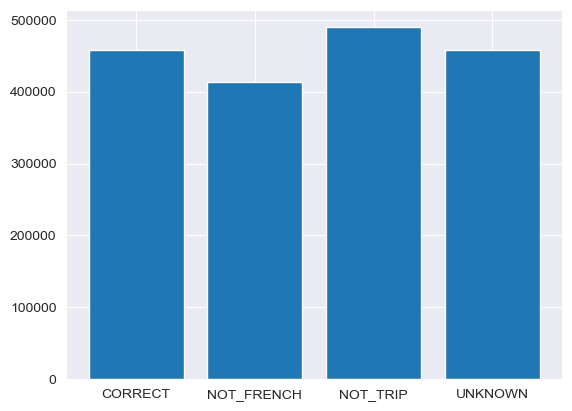

In [3]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset[label]) for label in labels])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
# Shuffle train dataset, and pick 50% of it
dataset = dataset.sample(frac=0.2, random_state=0)
X_train = dataset['text']
y_train = dataset[labels]

# To check how vectorizer works without UNKNOWN words being isolated
X_train_without_unknown = dataset[dataset['UNKNOWN'] == 0]['text']
y_train_without_unknown = dataset[dataset['UNKNOWN'] == 0][labels]

# Split test dataset into 10% validation and 10% test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(244630,) (30579,) (30579,)
(244630, 4) (30579, 4) (30579, 4)


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paramètres de tokenisation
vocab_size = 20000  # Choisissez une taille adaptée à votre vocabulaire
max_length = 100    # Longueur maximale des séquences

# Initialisation du tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Conversion des textes en séquences de tokens
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Padding des séquences pour qu'elles aient la même longueur
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Paramètres du modèle
vocab_size = 20000  # Taille de votre vocabulaire
max_length = 100    # Longueur maximale des séquences
embedding_dim = 128  # Dimension de l'embedding
lstm_units = 64      # Nombre d'unités dans la couche LSTM

# Construction du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(lstm_units))
model.add(Dense(4, activation='sigmoid'))  # Ajustez à 4 (ou au nombre de labels dans votre tâche)

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2,609,668
Trainable params: 2,609,668
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 3
model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_val_padded, y_val))


Epoch 1/3
7645/7645 [==============================] - 172s 21ms/step - loss: 0.0180 - accuracy: 0.9089 - val_loss: 0.0048 - val_accuracy: 0.8538
Epoch 2/3
7645/7645 [==============================] - 161s 21ms/step - loss: 0.0016 - accuracy: 0.8827 - val_loss: 0.0015 - val_accuracy: 0.9161
Epoch 3/3
7645/7645 [==============================] - 169s 22ms/step - loss: 7.8445e-04 - accuracy: 0.8580 - val_loss: 9.6439e-04 - val_accuracy: 0.8434


In [8]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

print(classification_report(y_test, y_pred_binary, target_names=labels))

956/956 [==============================] - 17s 15ms/step
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      9092
  NOT_FRENCH       1.00      1.00      1.00      8156
    NOT_TRIP       1.00      1.00      1.00      9746
     UNKNOWN       1.00      1.00      1.00      9306

   micro avg       1.00      1.00      1.00     36300
   macro avg       1.00      1.00      1.00     36300
weighted avg       1.00      1.00      1.00     36300
 samples avg       1.00      1.00      1.00     36300



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
print("Distribution des labels dans l'ensemble d'entraînement :")
print(y_train.sum(axis=0))  # Somme pour chaque label dans y_train

print("\nDistribution des labels dans l'ensemble de test :")
print(y_test.sum(axis=0))   # Somme pour chaque label dans y_test


Distribution des labels dans l'ensemble d'entraînement :
CORRECT       72922
NOT_FRENCH    66650
NOT_TRIP      78643
UNKNOWN       73264
dtype: int64

Distribution des labels dans l'ensemble de test :
CORRECT       9092
NOT_FRENCH    8156
NOT_TRIP      9746
UNKNOWN       9306
dtype: int64


In [10]:
from sklearn.metrics import classification_report
import numpy as np

for threshold in np.arange(0.1, 0.9, 0.1):
    y_pred_binary = (y_pred > threshold).astype(int)
    print(f"Seuil: {threshold}")
    print(classification_report(y_test, y_pred_binary, target_names=labels))


Seuil: 0.1
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      9092
  NOT_FRENCH       1.00      1.00      1.00      8156
    NOT_TRIP       1.00      1.00      1.00      9746
     UNKNOWN       1.00      1.00      1.00      9306

   micro avg       1.00      1.00      1.00     36300
   macro avg       1.00      1.00      1.00     36300
weighted avg       1.00      1.00      1.00     36300
 samples avg       1.00      1.00      1.00     36300

Seuil: 0.2
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      9092
  NOT_FRENCH       1.00      1.00      1.00      8156
    NOT_TRIP       1.00      1.00      1.00      9746
     UNKNOWN       1.00      1.00      1.00      9306

   micro avg       1.00      1.00      1.00     36300
   macro avg       1.00      1.00      1.00     36300
weighted avg       1.00      1.00      1.00     36300
 samples avg       1.00      1.00      1.00     36300



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metr

In [11]:
indices = np.random.choice(range(len(y_test)), 10, replace=False)  # Choisir 10 échantillons au hasard
for i in indices:
    print("Vrai label:", y_test.iloc[i].to_list())
    print("Prédiction:", y_pred_binary[i])
    print()


Vrai label: [1, 0, 0, 0]
Prédiction: [1 0 0 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]

Vrai label: [0, 1, 0, 0]
Prédiction: [0 1 0 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 1, 0]
Prédiction: [0 0 1 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]



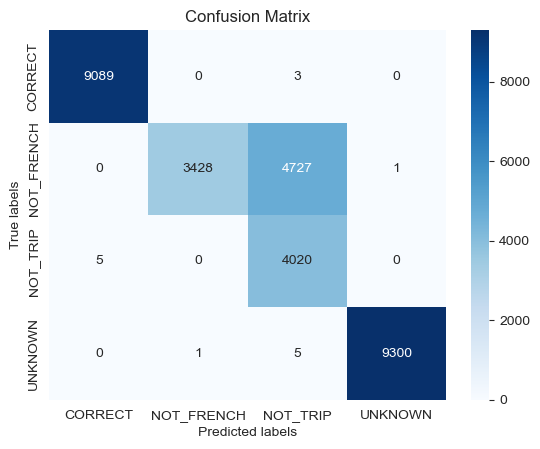

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

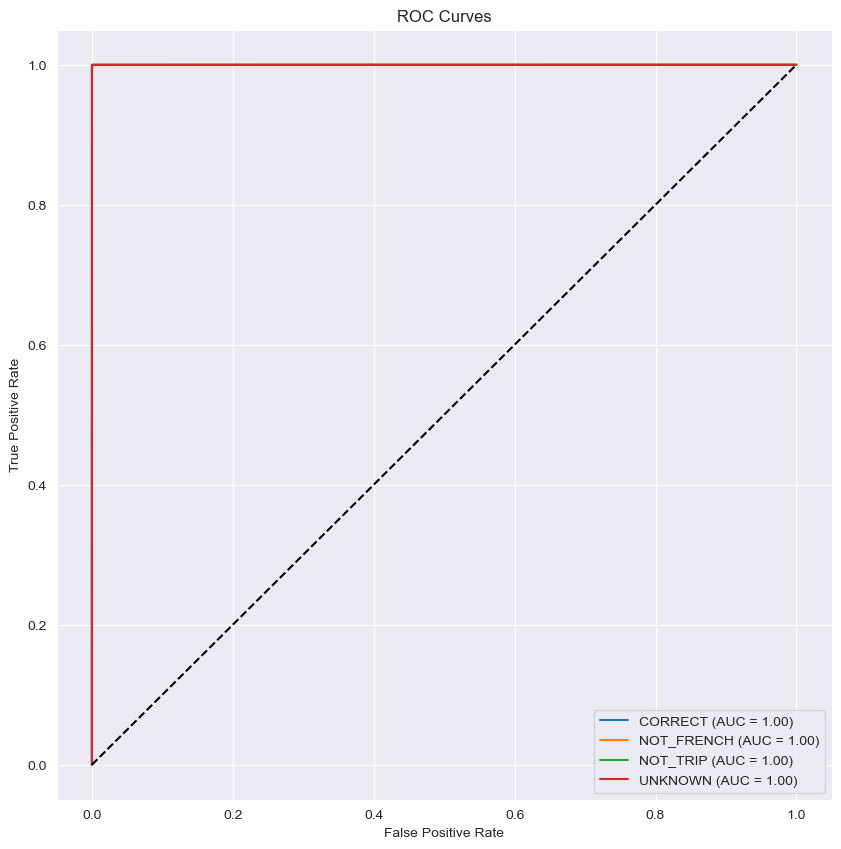

In [13]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))

for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [14]:
new_texts = [
    "Je veux aller au cinéma",
    "Je veux aller du cinéma au restaurant",
    "I'd like to go from the cinema to the restaurant",
    "I'd like to Paris from Nanterre",
    "zaeazea eaz e:az e,az e\"zahoiplù;!:gf",
    "J'aimerais me rendre de Nanterre à Paris",
    "Je veux aller de Le Havre à Port-Boulet",
    "Nantes à Toulouse",
    "Dirige moi vers Lyon depuis Saint-Étienne.",
    "Trouve moi un itinéraire pour aller chez Emma de Paris à Marseille",
]
new_texts_sequences = tokenizer.texts_to_sequences(new_texts)
new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_length)

predicted_labels = model.predict(new_texts_padded)

# Affichage des labels prédits
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print("Predicted labels:")
    for j, label in enumerate(labels):
        print(f" - {label}: {round(predicted_labels[i][j] * 100, 2)}%")


1/1 [==============================] - 0s 78ms/step
Text: Je veux aller au cinéma
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 0.08%
 - NOT_TRIP: 100.0%
 - UNKNOWN: 0.0%
Text: Je veux aller du cinéma au restaurant
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 0.02%
 - NOT_TRIP: 100.0%
 - UNKNOWN: 0.0%
Text: I'd like to go from the cinema to the restaurant
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 100.0%
 - NOT_TRIP: 77.4%
 - UNKNOWN: 0.0%
Text: I'd like to Paris from Nanterre
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 100.0%
 - NOT_TRIP: 0.93%
 - UNKNOWN: 0.02%
Text: zaeazea eaz e:az e,az e"zahoiplù;!:gf
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 4.69%
 - NOT_TRIP: 0.13%
 - UNKNOWN: 93.61%
Text: J'aimerais me rendre de Nanterre à Paris
Predicted labels:
 - CORRECT: 85.88%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 7.07%
 - UNKNOWN: 0.01%
Text: Je veux aller de Le Havre à Port-Boulet
Predicted labels:
 - CORRECT: 7.8%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 93.62%
 - UNKNO